# 4.7 추론 실시

- 학습시킨 OpenPose로 자세 추정을 실시합니다.


# 학습 목표


1.	OpenPose의 학습된 모델을 로드할 수 있다
2.	OpenPose 추론을 구현할 수 있다



# 사전 준비

- "weights" 폴더에 학습된 가중치 파라미터 "pose_model_scratch.pth"를 준비한다.

https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation

https://www.dropbox.com/s/5v654d2u65fuvyr/pose_model_scratch.pth?dl=0


In [1]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [2]:
from utils.openpose_net import OpenPoseNet

# 학습된 모델과 이 장의 모델은 네트워크 계층의 이름이 다르므로 대응시켜 로드한다
# 모델 정의
net = OpenPoseNet()

# 학습된 파라미터를 읽는다
net_weights = torch.load(
    './weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# 로드한 내용을 이 책에서 구축한 모델의
# 파라미터명 net.state_dict().keys()로 복사
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# 복사한 내용을 모델에 할당
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')


네트워크 설정 완료: 학습된 가중치를 로드했습니다


In [3]:
# 야구 화상을 읽어, 전처리합니다
test_image = './data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,R의 순서

# BGR을 RGB로 하여 표시
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 화상 리사이즈
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 화상 전처리
img = img.astype(np.float32) / 255.

# 색상 정보의 표준화
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# (높이, 폭, 색) → (색, 높이, 폭)
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 화상을 Tensor로
img = torch.from_numpy(img)

# 미니 배치화: torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [4]:
# OpenPose로 heatmaps과 PAFs를 구합니다
net.eval()
predicted_outputs, _ = net(x)

# 화상을 텐서에서 NumPy로 변환해, 크기를 반환합니다
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

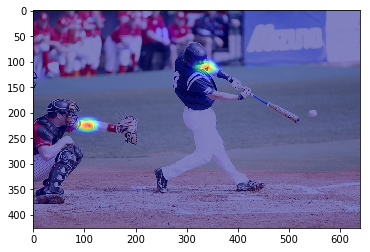

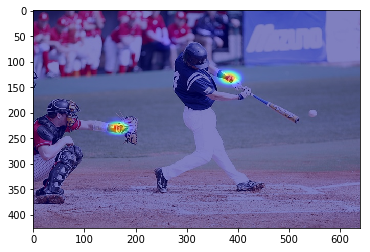

In [5]:
# 왼쪽 팔꿈치와 왼쪽 손목의 heatmap, 그리고 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터를 시각화한다
# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [6]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

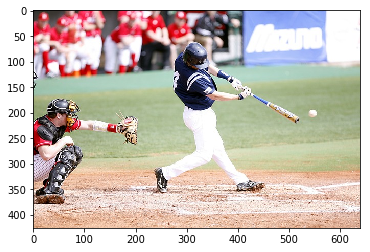

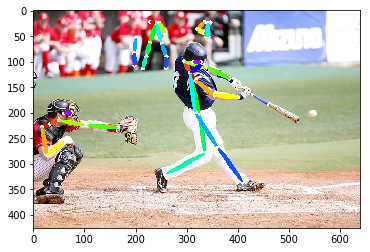

In [7]:
# 결과를 화면에 그리기
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

끝